# Battle of the Neighborhoods: Toronto

### Part 1: Scraping of Toronto Neighborhood Data from Wikipedia and Cleaning Data

Code for part 1 adapted from: https://www.youtube.com/watch?v=ICXR9nDbudk, Web Scraping Wikipedia Tables using Python by Jie Jeng
Website: https://LearnDataAnalysis.org

In [110]:
#Loading Packages: Pandas, Beautiful Soup and Requests
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

In [111]:
#Grabbing Wikipedia URL and Table ID as variables, then grabbing from wikipedia using Beautiful Soup
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
table = 'table'

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
ttable = soup.find_all('table')[0]

df = pd.read_html(str(ttable))
#Converting List to Dataframe
df = df[0]
#Displaying First 5 Lines of Dataframe and shape of imported dataframe
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [112]:
#Processing Neighborhood Dataframe

#Dropping rows where Borough is not assigned, assinging variables tneighborhoods
tneighborhoods = df[df['Borough'] != 'Not assigned']

#Combining Neighborhoods by Postal Code
tneighborhoods = tneighborhoods.groupby(['Postal Code']).sum().drop_duplicates()

The next step suggests that we replace any unassigned neighborhoods with their borough name. I was not able to find any unassigned neighborhoods and even resorted to a manual check via exporting to csv to confirm.

In [113]:
#Exporting to CSV to check for unassigned neighborhoods
#tneighborhoods.to_csv('TCheck.csv')

#Cleaning Data
#I did not find any unassigned neighborhoods. Being unfamilar with the geography of the city I didn't want to needlessly clean any neighborhoods that would be useful in later analysis
#But, I did settle on removing 2 postal codes, since they indiated that they were both functions of the postal office. 
# M7R Post Gateway Processing Centre : M7Y Business reply mail Processing Centre, South Central Letter Processing Plant Toronto
tneighborhoods = tneighborhoods[tneighborhoods['Neighbourhood'] != 'Canada Post Gateway Processing Centre']
tneighborhoods = tneighborhoods[tneighborhoods['Neighbourhood'] != 'Business reply mail Processing Centre, South Central Letter Processing Plant Toronto']

#Resetting Index to be more like suggested start dataframe
tneighborhoods.reset_index(inplace = True)

tneighborhoods.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [114]:
#Finally for this section I showed the overall shape of the dataframe
tneighborhoods.shape

(97, 3)

#### This Marks the end of Part 1 of the Lab.

### Part 2: Adding Geolocation Data to Dataset

In [115]:
#Importing Requied Packages (Geocoder)
import geocoder

Although I tried the code to get lat, longitude using geocoder, it always ended up timing and and not producing results. Therefore I switched to using the .csv file provided.

In [116]:
#Importing Latitude Longitude csv file
latlong = pd.read_csv('C:\\Users\\Hiroshi\\Desktop\\GitProjects\\datasciencecapstone\\Geospatial_Coordinates.csv')
latlong.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [117]:
#Merging Dataframes using Postal Code
neigh = pd.merge(tneighborhoods, latlong, left_on = 'Postal Code', right_on = 'Postal Code', how = 'left')
neigh.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


#### This marks the end of Part 2 of the Lab

### Part 3: Exploring the Neighborhoods of Toronto using SquareSpace

In [118]:
#First we need to import new libraries from the New York Lab
import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

In [119]:
#Getting Address of Toronto, Canada
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [21]:
#Creating Map of Toronto
map = folium.Map(location=(latitude, longitude), zoom_start=11)

#Creating Markers
for lat, lng, borough, neighbourhood in zip(neigh['Latitude'], neigh['Longitude'], neigh['Borough'], neigh['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  

display(map)

There are many neighborhoods of Toronto, and we want to limit the scope of our project somehwat. To do that, we need to employ some data cleaning. Let's say our hypothetical consumer is interested in examining the amenities offered in Urban, Suburban, and exurban areas of the city. Let's start by trying to get a sense of the population in Toronto by Zipcode

Data was pulled from Canda's official Census conducted in 2016: https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&SR=1&S=22&O=A&RPP=9999&PR=0

I cleaned all rows except for Postal Code and Population outside of Python

In [120]:
#Importing Population Data and Merging it with our 'neigh' dataset
pop = pd.read_csv('C:\\Users\\Hiroshi\\Desktop\\GitProjects\\datasciencecapstone\\canpop.csv')

#Merging Datasets together, using Postal Code as key value
neigh1 = pd.merge(neigh, pop, left_on = 'Postal Code', right_on = 'Postal Code', how = 'left')

neigh1.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Population
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,66108.0
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,35626.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,46943.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,29690.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,24383.0


In [121]:
#Next we want to sort this new table by population
neigh1.sort_values(by = 'Population', inplace = True)

neigh1.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Population
56,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,0.0
57,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,0.0
81,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,10.0
66,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,10.0
65,M5W,Downtown Toronto,Stn A PO Boxes,43.646435,-79.374846,15.0


In [122]:
#The inclusion of population has allowed us to identify a few places that don't seem super relvant to our search
#Let's get rid of them by passing through areas whose population is less than 100
neigh1 = neigh1[neigh1['Population'] > 100]
neigh1.shape

(92, 6)

In [123]:
#Let's take a closer look at the population using plots
#Importing plt function
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

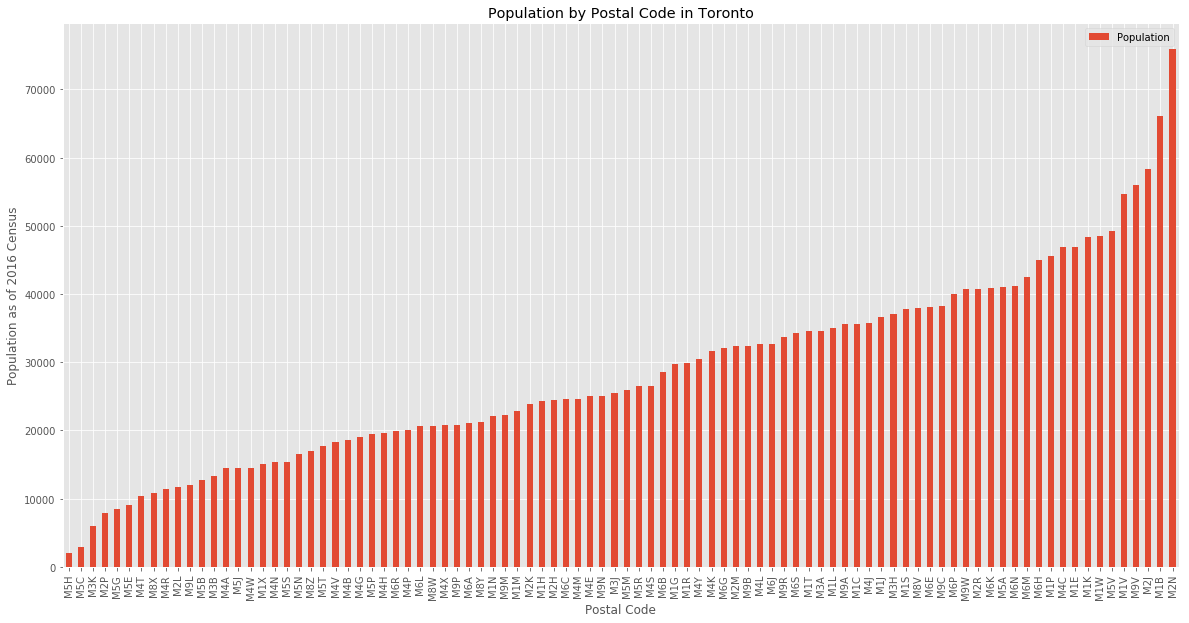

In [124]:
ax = neigh1.plot(x ='Postal Code', y='Population', kind = 'bar', figsize = (20,10))
ax = plt.ylabel('Population as of 2016 Census')
ax = plt.title('Population by Postal Code in Toronto')

An interesting question would be to analyze how similar the largest, smallest, and midsize neighborhoods in Toronto are to other neighborhoods in that category.

Lets split the database into low (under 20k) medium (20 to 35k) and high (over 35k) and example results in that manner.

In [125]:
neighlow = neigh1[neigh1['Population'] < 20000]
neighmedium = neigh1[neigh1['Population'] < 35000]
neighmedium = neighmedium[neighmedium['Population'] >= 20000]
neighhigh = neigh1[neigh1['Population'] >= 35000]

print("Neighlow stats", neighlow.shape)
print("Neighmedium stats", neighmedium.shape)
print("Neighhigh stats", neighhigh.shape)

Neighlow stats (28, 6)
Neighmedium stats (35, 6)
Neighhigh stats (29, 6)


While these bins are a bit arbitrary, they have roughly the same number of groups, which could be beneficial in cross analysis. Let's continue exploring the data by recreating the map of Toronto but by distinguishing population size via color.

In [126]:
#Creating Map of Toronto
map = folium.Map(location=(latitude, longitude), zoom_start=11)

#Creating Markers
for lat, lng, borough, neighbourhood in zip(neighlow['Latitude'], neighlow['Longitude'], neighlow['Borough'], neighlow['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
for lat, lng, borough, neighbourhood in zip(neighmedium['Latitude'], neighmedium['Longitude'], neighmedium['Borough'], neighmedium['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
for lat, lng, borough, neighbourhood in zip(neighhigh['Latitude'], neighhigh['Longitude'], neighhigh['Borough'], neighhigh['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        fill_color='orange',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  

display(map)

The map shows us some interesting patterns. We can see that small and medium size zip codes are clustered downtown, probably because they are geographicaly confined. This is especially true for small (blue) neighborhoods). In contrast, larger postal codes tend to be farther away from downtown, although there are some exceptions. This leads me to believe that these neighborhoods will probably have something in common with one another, across the board. Let's take a look.

In [127]:
#Loading Foursquare Credentials:
CLIENT_ID = 'DYCSDGLZKIWRQGI0OEVKWGKQED11L1LRTH4VZASZBS2X2HFS' # your Foursquare ID
CLIENT_SECRET = 'TXTFQPVUPQWV52TPYEQHOS5WF1NAXUQSODWQSI0R51G2RNVC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DYCSDGLZKIWRQGI0OEVKWGKQED11L1LRTH4VZASZBS2X2HFS
CLIENT_SECRET:TXTFQPVUPQWV52TPYEQHOS5WF1NAXUQSODWQSI0R51G2RNVC


In [128]:
#Resetting Index so that we can grab data easier
neighlow.reset_index(inplace = True)
neighmedium.reset_index(inplace = True)
neighhigh.reset_index(inplace = True)

In [129]:
neighlow.loc[0, 'Postal Code']
neighborhood_latitude = neighlow.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighlow.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_name = neighlow.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Richmond, Adelaide, King are 43.65057120000001, -79.3845675.


In [130]:
#Testing Out Radius -- needed 2500 in order to obtain significant results.
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=DYCSDGLZKIWRQGI0OEVKWGKQED11L1LRTH4VZASZBS2X2HFS&client_secret=TXTFQPVUPQWV52TPYEQHOS5WF1NAXUQSODWQSI0R51G2RNVC&v=20180605&ll=43.65057120000001,-79.3845675&radius=2500&limit=100'

In [131]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f419381cd347610a7f7922e'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Toronto',
  'headerFullLocation': 'Toronto',
  'headerLocationGranularity': 'city',
  'totalResults': 235,
  'suggestedBounds': {'ne': {'lat': 43.673071222500035,
    'lng': -79.35352940718016},
   'sw': {'lat': 43.62807117749998, 'lng': -79.41560559281984}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5227bb01498e17bf485e6202',
       'name': 'Downtown Toronto',
       'location': {'lat': 43.65323167517444,
        'lng': -79.38529600606677,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65323167517444,
          'lng': -79.38529600606677}],
   

In [132]:
#Borrowing the get Category Function from the previous lab
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [133]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [53]:
#Generalized Function to grab from dataset, rather than a singular one.
#I modified this function to incorporate the neighborhood tags and 
#reduced the radius so that the function could actually run without timing out
def getNearbyVenues(names, neighbourhoods, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, neigh, lat, lng in zip(names, neighbourhoods, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            neigh,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code', 'Neighbourhoods',
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [134]:
neighlow_venues = []

In [135]:
#Grabbing Venues for Low Population Zipcodes
neighlow_venues = getNearbyVenues(names=neighlow['Postal Code'], neighbourhoods=neighlow['Neighbourhood'], latitudes=neighlow['Latitude'], longitudes=neighlow['Longitude'])

M5H
M5C
M3K
M2P
M5G
M5E
M4T
M8X
M4R
M2L
M9L
M5B
M3B
M4A
M5J
M4W
M1X
M4N
M5S
M5N
M8Z
M5T
M4V
M4B
M4G
M5P
M4H
M6R


In [136]:
print(neighlow_venues.shape)
neighlow_venues.head()

(769, 8)


,Postal Code,Neighbourhoods,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M5H,"Richmond, Adelaide, King",43.650571,-79.384568,Nathan Phillips Square,43.652270,-79.383516,Plaza
1,M5H,"Richmond, Adelaide, King",43.650571,-79.384568,Four Seasons Centre for the Performing Arts,43.650592,-79.385806,Concert Hall
2,M5H,"Richmond, Adelaide, King",43.650571,-79.384568,Bosk at Shangri-La,43.649023,-79.385826,Asian Restaurant
3,M5H,"Richmond, Adelaide, King",43.650571,-79.384568,The Keg Steakhouse + Bar - York Street,43.649987,-79.384103,Restaurant
4,M5H,"Richmond, Adelaide, King",43.650571,-79.384568,Shangri-La Toronto,43.649129,-79.386557,Hotel


In [137]:
neighlow_venues.groupby('Postal Code').count()

,Neighbourhoods,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Postal Code,,,,,,,
M2P,2,2,2,2,2,2,2
M3B,6,6,6,6,6,6,6
M3K,4,4,4,4,4,4,4
M4A,5,5,5,5,5,5,5
M4B,10,10,10,10,10,10,10
M4G,32,32,32,32,32,32,32
M4H,20,20,20,20,20,20,20
M4N,3,3,3,3,3,3,3
M4R,18,18,18,18,18,18,18


One interesting thing might be to take a look at Resturants in the Area and categorize neighborhoods by the types of resturants available. After all, that's what many people get excited about when moving into an area -- what type of food is available.

In [138]:
resturants = neighlow_venues[neighlow_venues['Venue Category'].str.contains('Res')]
resturants.reset_index()

,index,Postal Code,Neighbourhoods,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,2,M5H,"Richmond, Adelaide, King",43.650571,-79.384568,Bosk at Shangri-La,43.649023,-79.385826,Asian Restaurant
1,3,M5H,"Richmond, Adelaide, King",43.650571,-79.384568,The Keg Steakhouse + Bar - York Street,43.649987,-79.384103,Restaurant
2,6,M5H,"Richmond, Adelaide, King",43.650571,-79.384568,Rosalinda,43.650252,-79.385156,Vegetarian / Vegan Restaurant
3,12,M5H,"Richmond, Adelaide, King",43.650571,-79.384568,John & Sons Oyster House,43.650656,-79.381613,Seafood Restaurant
4,16,M5H,"Richmond, Adelaide, King",43.650571,-79.384568,JaBistro,43.649687,-79.388090,Sushi Restaurant
5,19,M5H,"Richmond, Adelaide, King",43.650571,-79.384568,Cactus Club Cafe,43.649552,-79.381671,American Restaurant
6,28,M5H,"Richmond, Adelaide, King",43.650571,-79.384568,Kojin,43.649398,-79.386091,Colombian Restaurant
7,29,M5H,"Richmond, Adelaide, King",43.650571,-79.384568,The Burger's Priest,43.648643,-79.387539,Fast Food Restaurant
8,30,M5H,"Richmond, Adelaide, King",43.650571,-79.384568,Pai,43.647923,-79.388579,Thai Restaurant
9,33,M5H,"Richmond, Adelaide, King",43.650571,-79.384568,Copacabana Grilled Brazilian,43.648333,-79.388151,Brazilian Restaurant


In [139]:
# one hot encoding
res_onehot = pd.get_dummies(resturants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
res_onehot['Postal Code'] = resturants['Postal Code']
res_onehot['Neighbourhoods'] = resturants['Neighbourhoods'] 

# move neighborhood column to the first column
fixed_columns = [res_onehot.columns[-1]] + list(res_onehot.columns[:-1])

res_onehot = res_onehot[fixed_columns]

fixed_columns = [res_onehot.columns[-1]] + list(res_onehot.columns[:-1])
res_onehot = res_onehot[fixed_columns]

res_onehot.head()

,Postal Code,Neighbourhoods,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,...,Moroccan Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
2,M5H,"Richmond, Adelaide, King",0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M5H,"Richmond, Adelaide, King",0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,M5H,"Richmond, Adelaide, King",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12,M5H,"Richmond, Adelaide, King",0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
16,M5H,"Richmond, Adelaide, King",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [146]:
res_onehot = res_onehot.groupby('Postal Code').mean().reset_index()
res_onehot

,Postal Code,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,...,Moroccan Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,M3B,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,M4A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,M4G,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000
3,M4H,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000
4,M4R,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000
5,M4V,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000,0.000000,0.250000
6,M5B,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.00,...,0.000000,0.047619,0.000000,0.095238,0.047619,0.047619,0.047619,0.047619,0.000000,0.047619
7,M5C,0.136364,0.045455,0.045455,0.000000,0.000000,0.000000,0.000000,0.045455,0.00,...,0.090909,0.045455,0.000000,0.000000,0.136364,0.090909,0.000000,0.045455,0.045455,0.000000
8,M5E,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.00,...,0.000000,0.000000,0.000000,0.000000,0.153846,0.153846,0.076923,0.076923,0.076923,0.000000
9,M5G,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.052632,0.052632,0.052632,0.052632,0.052632,0.052632,0.052632,0.052632,0.000000


In [147]:
# set number of clusters
kclusters = 5

res_onehot_clustered = res_onehot.drop('Postal Code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters).fit(res_onehot_clustered)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 4, 0, 0, 0, 0, 0, 0, 0, 0])

In [148]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [149]:
res_grouped = res_onehot.groupby('Postal Code').mean().reset_index()
res_grouped

,Postal Code,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,...,Moroccan Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,M3B,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,M4A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,M4G,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000
3,M4H,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000
4,M4R,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.000000,0.000000,0.000000,0.000000
5,M4V,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000,0.000000,0.250000
6,M5B,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.00,...,0.000000,0.047619,0.000000,0.095238,0.047619,0.047619,0.047619,0.047619,0.000000,0.047619
7,M5C,0.136364,0.045455,0.045455,0.000000,0.000000,0.000000,0.000000,0.045455,0.00,...,0.090909,0.045455,0.000000,0.000000,0.136364,0.090909,0.000000,0.045455,0.045455,0.000000
8,M5E,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.00,...,0.000000,0.000000,0.000000,0.000000,0.153846,0.153846,0.076923,0.076923,0.076923,0.000000
9,M5G,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.052632,0.052632,0.052632,0.052632,0.052632,0.052632,0.052632,0.052632,0.000000


In [175]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postal Code'] = res_grouped['Postal Code']

for ind in np.arange(res_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(res_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Postal Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3B,Japanese Restaurant,Caribbean Restaurant,Vietnamese Restaurant,Doner Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant
1,M4A,French Restaurant,Portuguese Restaurant,Dim Sum Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Doner Restaurant
2,M4G,Mexican Restaurant,Sushi Restaurant,Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant,Doner Restaurant
3,M4H,Indian Restaurant,Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Dim Sum Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant
4,M4R,Mexican Restaurant,Fast Food Restaurant,Seafood Restaurant,Restaurant,Chinese Restaurant,Vietnamese Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant,Dumpling Restaurant


In [176]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighlow_merged = neighlow

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
neighlow_merged = neighlow_merged.join(neighborhoods_venues_sorted.set_index('Postal Code'), on='Postal Code')
neighlow_merged['Cluster Labels'] = neighlow_merged['Cluster Labels'].fillna(5)
neighlow_merged.head() # check the last columns!

,index,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,54,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,2005.0,0.0,Restaurant,Thai Restaurant,American Restaurant,Sushi Restaurant,Mediterranean Restaurant,Asian Restaurant,Brazilian Restaurant,Colombian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant
1,51,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2951.0,0.0,American Restaurant,Restaurant,Seafood Restaurant,Moroccan Restaurant,Italian Restaurant,Asian Restaurant,Thai Restaurant,Belgian Restaurant,New American Restaurant,French Restaurant
2,29,M3K,North York,Downsview,43.737473,-79.464763,5997.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23,M2P,North York,York Mills West,43.752758,-79.400049,7843.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,53,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,8423.0,0.0,Italian Restaurant,Japanese Restaurant,Modern European Restaurant,Middle Eastern Restaurant,French Restaurant,Indian Restaurant,Korean Restaurant,Falafel Restaurant,Vegetarian / Vegan Restaurant,New American Restaurant


In [186]:
#Setting Cluster Label as Integer so It plays better with the labeling later.
neighlow_merged['Cluster Labels'] = neighlow_merged['Cluster Labels'].astype(int)

#Creating Cluster Labels
cluster_dictionary = {0: 'Japanese & East Asian', 1: 'European Mixed', 2: 'Mexican and Asian Fusion', 3: 'Indian and Fast Food',
                     4: 'Mexican and Fast Food', 5: 'No Resturants'}
neighlow_merged['Cluster Description'] = neighlow_merged['Cluster Labels'].map(cluster_dictionary)
neighlow_merged.head()

,index,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Description
0,54,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,2005.0,0,Restaurant,Thai Restaurant,American Restaurant,Sushi Restaurant,Mediterranean Restaurant,Asian Restaurant,Brazilian Restaurant,Colombian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Japanese & East Asian
1,51,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2951.0,0,American Restaurant,Restaurant,Seafood Restaurant,Moroccan Restaurant,Italian Restaurant,Asian Restaurant,Thai Restaurant,Belgian Restaurant,New American Restaurant,French Restaurant,Japanese & East Asian
2,29,M3K,North York,Downsview,43.737473,-79.464763,5997.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Resturants
3,23,M2P,North York,York Mills West,43.752758,-79.400049,7843.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Resturants
4,53,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,8423.0,0,Italian Restaurant,Japanese Restaurant,Modern European Restaurant,Middle Eastern Restaurant,French Restaurant,Indian Restaurant,Korean Restaurant,Falafel Restaurant,Vegetarian / Vegan Restaurant,New American Restaurant,Japanese & East Asian


In [206]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters + 1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, lab in zip(neighlow_merged['Latitude'], neighlow_merged['Longitude'], neighlow_merged['Borough'], neighlow_merged['Cluster Labels'], 
                                      neighlow_merged['Cluster Description']):
    label = folium.Popup(str(poi) + ' ' + lab, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Overall all areas have a good variety of resturants, with the exception of the Orange Dots which don't seem to have any listed (according to Foursquare). The Red Dots Represent East Asian and Japanese food being most dominant, while the other colors indicate other types of resturants in the area, although all have good variety. 

The next Step would be to do the same for other areas with larger populations, but I will save that for another time.

#### This Marks the end of Part 3 of the Lab.